In [1]:
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
import os
import pandas as pd
import matplotlib.pyplot as plt

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
warnings.filterwarnings("ignore", category=Warning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda:0


In [4]:
df = pd.read_csv('../data/pharos/esm2_320_dimensions_with_labels.csv') 
X = df.drop(['label', 'UniProt_id'], axis=1)
y = df['label'].apply(lambda x: 0 if x != 1 else x)

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [5]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(320, 180)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(180, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 30)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [6]:
model = Deep()

In [7]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

2023-11-28 15:23:52.176389: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 15:23:52.198319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 15:23:52.198340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 15:23:52.198382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 15:23:52.202727: I tensorflow/core/platform/cpu_feature_g

Accuracy (deep): 0.86
Accuracy (deep): 0.87
Accuracy (deep): 0.86
Accuracy (deep): 0.87
Accuracy (deep): 0.86
Deep: 86.26% (+/- 0.66%)
train a deep model
Final model accuracy: 87.37%
[-1.84363246e-01 -3.90404493e-01  1.64655000e-01  1.94118172e-01
 -5.59002049e-02 -1.63746476e-01 -3.21565792e-02  5.52224964e-02
 -6.31510168e-02  5.07709421e-02 -1.05393469e-01  4.19655085e-01
 -5.97111918e-02  3.26843917e-01 -2.02462733e-01 -5.07184900e-02
  7.34063461e-02 -1.26056671e-01 -1.65439501e-01 -1.49020422e-02
 -2.38350138e-01  1.11407548e-01 -1.35518432e-01  3.16555798e-02
 -1.54653972e-03  4.97328758e-01  1.79356322e-01  6.14989847e-02
  2.01274022e-01 -2.93183308e-02  1.44039273e-01 -2.43445560e-01
  1.78392097e-01 -1.80547863e-01  1.96253330e-01 -3.85661960e-01
  1.23574674e-01  5.53100817e-02  1.43162161e-01 -1.87154561e-02
 -1.06170490e-01  1.40690699e-01  4.13109481e-01  6.36037514e-02
 -1.81456551e-01 -3.82757410e-02 -1.05242050e+00  9.49500501e-02
 -1.13589317e-01  1.28917350e-02 -1.3

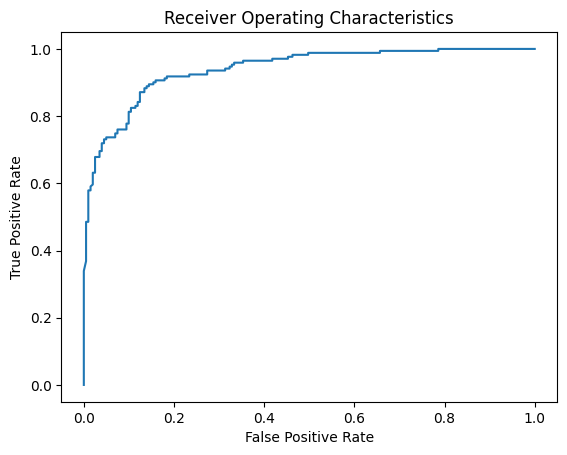

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_deep = []

for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)


deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))


print("train a deep model")
model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1].to(device)).cpu()
        print(f"{X_test[i].cpu().numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    y_pred = model(X_test.to(device)).cpu()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()